**MLP классификатор** 

Евгений Борисов  <esborisov@sevsu.ru>

О методах обучения многослойных нейронных сетей прямого распространения.    
http://mechanoid.su/neural-net-backprop.html  
http://mechanoid.su/neural-net-backprop2.html

---

In [1]:
import numpy as np
from numpy import random as rng

import matplotlib.pyplot as plt

%precision 3
np.set_printoptions(precision=2)
np.set_printoptions(linewidth=110)
# np.get_printoptions()

# генерируем данные

In [2]:
from sklearn.datasets import make_circles
X,target = make_circles(n_samples=1024, shuffle=True, noise=.09, factor=.3)

# from sklearn.datasets import make_moons
# X,target = make_moons(n_samples=1024, noise=.09)

display(X.shape, target.shape)

(1024, 2)

(1024,)

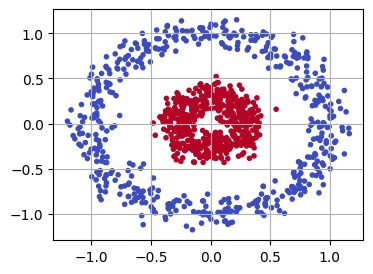

In [3]:
fig,ax = plt.subplots( figsize=(4,3),)
ax.scatter(x=X[:,0],y=X[:,1],c=target, marker='.', cmap='coolwarm')
ax.grid()

In [4]:
# нормируем данные

# from sklearn.preprocessing import MinMaxScaler
# X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

# from sklearn.preprocessing   import StandardScaler
# X = StandardScaler().fit(X).transform(X)

# display( X.min(),np.mean(X),np.median(X),X.max() 

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, target_train, target_test = train_test_split(X,target,test_size=.5)
display( x_train.shape, x_test.shape, )

assert len(target_train) == len(x_train)
assert len(target_test) == len(x_test)

del X,target

(512, 2)

(512, 2)

In [6]:
y_train = np.eye(2)[target_train]
y_test  = np.eye(2)[target_test]

display(y_train.shape, y_test.shape)

(512, 2)

(512, 2)

---

In [7]:
# import numpy as np
# from numpy import random as rng
# from matplotlib import pyplot as plt

In [8]:
# from random import sample
# from tqdm.auto import tqdm
# from itertools import chain

# строим модель

схема нейрона

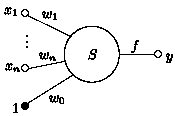

## линейный слой

In [62]:
class Linear:
    
    def __init__(self,in_size,out_size):
        self._weight = rng.normal(loc=0.,scale=1e-2,size=(in_size,out_size))
        self._bias = np.zeros(shape=(1,out_size))
        
    def forward(self,x):
        assert len(x)>0
        assert x.shape[-1]==self._weight.shape[0]
        return x.dot(self._weight)+self._bias

    def forward_train(self,x):
        return self.forward(x)
    
    def backward(self,d):
        return d.dot(self._weight.T)
    
    def gradient(self,x,d):
        return x.T.dot(d), d.sum(axis=0,keepdims=True) 
    
    def __call__(self,x):
        return self.forward(x)
    
    @property
    def weight(self):
        return self._weight, self._bias

    @weight.setter
    def weight(self,w):
        self._weight=w[0] 
        self._bias=w[1]
        return self

In [63]:
# display((x_train.shape,y_train.shape))

# model = Linear(in_size=x_train.shape[1],out_size=y_train.shape[1])

# o = model(x_train)
# display(o.shape)

# o = model.forward_train(x_train)
# display(o.shape)

# d = model.backward(y_train-o)
# display(d.shape)

# dw,db = model.gradient(x_train,d)
# display((dw.shape,db.shape))

## функция активации

In [64]:
class BiSigmoid:
    
    def forward(self,x): 
        return np.tanh(x)

    def backward(self,x): # производная активации
        return 1./(np.cosh(x)**2)
    
    def __call__(self,x):
        return self.forward(x)

Text(0.5, 1.0, 'd bi_sigmoid')

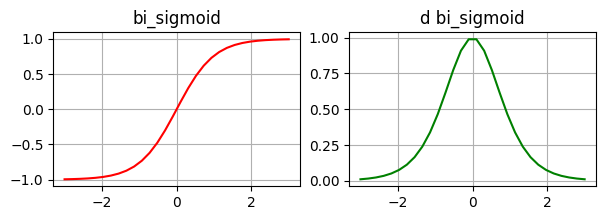

In [65]:
f = BiSigmoid()
x = np.linspace(-3,3,30)
fig,ax = plt.subplots(ncols=2,figsize=(7,2))
ax[0].plot(x,f(x),'-r')
ax[0].grid()
ax[0].set_title('bi_sigmoid' )
ax[1].plot(x,f.backward(x),'-g')
ax[1].grid()
ax[1].set_title('d bi_sigmoid' )

In [66]:
class Sigmoid: # функция активации
    
    def forward(self,x): 
        return 1./(1. + np.exp(-x))

    def backward(self,x): # производная активации
        return np.square(self.forward(x))*np.exp(-x) 
    
    def __call__(self,x):
        return self.forward(x)

Text(0.5, 1.0, 'd sigmoid')

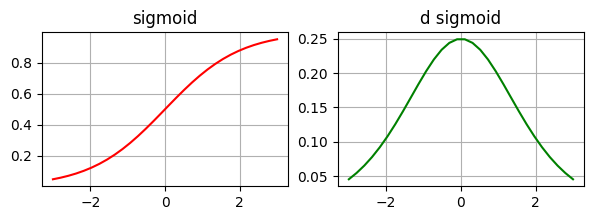

In [67]:
f = Sigmoid()
x = np.linspace(-3,3,30)
fig,ax = plt.subplots(ncols=2,figsize=(7,2))
ax[0].plot(x,f(x),'-r')
ax[0].grid()
ax[0].set_title('sigmoid' )
ax[1].plot(x,f.backward(x),'-g')
ax[1].grid()
ax[1].set_title('d sigmoid' )

схема MPL 

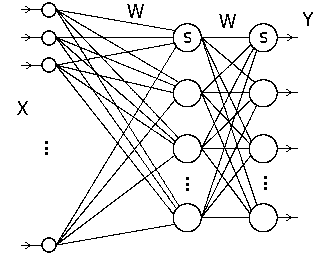

градиент функции потери - частные производные по всем параметрам модели, направление наискорейшего возрастания функции 

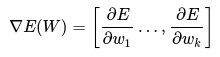


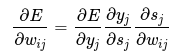

процедура обратного распространения ошибки

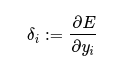

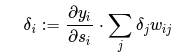

In [68]:
class MLP3:
    
    def __init__(self,in_size,hidden_size,out_size):
        self._activation0 = BiSigmoid()
        self._activation1 = Sigmoid()
        
        self._lin0 = Linear(in_size,hidden_size[0])
        self._lin1 = Linear(hidden_size[0],hidden_size[1])
        self._lin2 = Linear(hidden_size[1],out_size)
                
    @property
    def weight(self):
        return self._lin0.weight, self._lin1.weight, self._lin2.weight

    @weight.setter
    def weight(self,w):
        self._lin0.weight=w[0] 
        self._lin1.weight=w[1]
        self._lin2.weight=w[2]
        return self
    
    def forward(self,x):
        assert len(x)>0
        o = self._lin0(x)
        o = self._activation0(o)
        o = self._lin1(o)
        o = self._activation0(o)
        o = self._lin2(o)
        o = self._activation1(o)
        return o
    
    def __call__(self,x):
        return self.forward(x)
    
    def forward_train(self,x):
        state,out = [x],[x]
        
        s = self._lin0.forward_train(out[-1])
        state.append(s)
        o = self._activation0(s)
        out.append(o)
        
        s = self._lin1.forward_train(out[-1])
        state.append(s)
        o = self._activation0(s)
        out.append(o)
        
        s = self._lin2.forward_train(out[-1])
        state.append(s)
        o = self._activation1(s)
        out.append(o)
        
        return state, out
    
    def backward(self,d,state):
        delta = [ d*self._activation1.backward(state[3]) ]
        delta.append( self._lin2.backward( delta[-1]  ) * self._activation0.backward( state[2]) )
        delta.append( self._lin1.backward( delta[-1]  ) * self._activation0.backward( state[1]) )
        delta.append( self._lin0.backward( delta[-1]  ) ) # * self._activation0.backward( state[0]) )
        return delta[::-1] 
    
    def gradient(self,x,out,delta):
        dw0,db0 = self._lin0.gradient(out[0],delta[1])    
        dw1,db1 = self._lin1.gradient(out[1],delta[2])    
        dw2,db2 = self._lin1.gradient(out[2],delta[3])    
        return [dw0,db0],[dw1,db1],[dw2,db2] 

    def predict(self,x):
        return np.argmax(self.forward(x),axis=-1)

In [69]:
# display((x_train.shape,y_train.shape))

# model = MLP3(in_size=x_train.shape[1],hidden_size=[10,5],out_size=y_train.shape[1])

# # o = model(x_train)
# # display(o.shape)

# s,o = model.forward_train(x_train)
# display( ( (len(s), s[-1].shape), ( len(o), o[1].shape,) ) )

# d = model.backward(y_train-o[-1],s)
# display( ( len(d), d[-1].shape ) )

# # [dw0,db0],[dw1,db1],[dw2,db2] = model.gradient(x_train,o,d)
# # display(((dw0.shape,db0.shape),(dw1.shape,db1.shape),(dw2.shape,db2.shape)))

# обучаем модель

функция потери средняя квадратичная ошибка
$$L=MSQE(y,o)=\frac{1}{m}\sum\limits_{i=0}^m(o_i-y_i)^2$$

In [70]:
class MSQELoss:
    
    def __init__(self,model): 
        self._model = model
        self._history = []
                
    def estimate(self,x,target):
        s = self._estimate( target, self._model(x))
        self._history.append(s)
        return s
        
    def _estimate(self,target,predicted):
        return np.square(target-predicted).mean()
    
    def gradient(self,x,target):
        s,o = model.forward_train(x) # состояния и выходы всех нейронов сети
        d0 = (o[-1]-target) # ошибка выходного слоя
        d = model.backward(d0,s) # значение ошибки для всех нейронов скрытых слоёв
        return model.gradient(x,o,d) 
    
    def __call__(self,x,target):
        return self.estimate(x,target)        
    
    @property
    def model(self): 
        return self._model

In [71]:
# display((x_train.shape,y_train.shape))

# model = MLP3(in_size=x_train.shape[1],hidden_size=[10,5],out_size=y_train.shape[1])

# o = model(x_train)
# display(o.shape)

# loss = MSQELoss(model)
# er = loss.estimate(x_train,y_train)
# display( er  )

# [dw0,db0],[dw1,db1] = loss.gradient(x_train,y_train)
# display((dw0.shape,db0.shape),(dw1.shape,db1.shape))

# обучаем

In [72]:
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

изменение весов

$$\Delta w_t = \eta \cdot ( \nabla L + \rho\cdot W_{t-1} ) + \mu\cdot \Delta w_{t-1}$$

In [73]:
class TrainSGD:
    
    def __init__(self,loss,lr=1e-2,mu=0.,rho=0.): 
        self._loss = loss
        self._dw = np.array([]) # изменение весов на предыдущем шаге
        self._mu = mu # коэфициент момента
        self._rho = rho # коэфициент регуляризации
        self._lr = lr
        
    def fit(self,x,t,n_epoch=128,batch_size=8):
        loss_history = [ self._loss.estimate(x,t) ]
        acc_history = [ accuracy_score(np.argmax(t,axis=-1),self._loss.model.predict(x)) ]
        self._zero_dw()
        for _ in tqdm(range(n_epoch)):
            for x_,t_ in self._get_batch(x,t,batch_size):
                self._fit_epoch(x_,t_)
            loss_history.append( self._loss.estimate(x,t) )
            acc_history.append( accuracy_score(np.argmax(t,axis=-1),self._loss.model.predict(x)) )
            if acc_history[-1]>.95: break
        return (acc_history,loss_history),model 
    
    def  _zero_dw(self): # начальное значение изменения весов
        w = self._loss.model.weight
        self._dw = [ 
                [ 0. for n in range(len(w[l])) ] # для каждого параметра слоя
                for l in range(len(w)) # для каждого слоя
            ]
        return self

    def _fit_epoch(self,x,t):
        dw = self._loss.gradient(x,t)
        dw = self._weight_norm(dw)
        self._weight_adjust(dw)  
        return self
    
    
    def _weight_adjust(self,dw):
        w = self._loss.model.weight
        dw = self._weight_delta(dw)
        self._loss.model.weight = [ 
                [ w[l][n] - dw[l][n] for n in range(len(w[l])) ] # для каждого параметра слоя
                for l in range(len(w)) # для каждого слоя
            ]
        return self
        
    
    def _weight_delta(self,dw): # вычисляем изменение всех весов модели
        w = self._loss.model.weight
        self._dw = [ 
                [ 
                    self._weight_delta_formula(
                        w[l][n], # веса
                        dw[l][n], # градиент
                        self._dw[l][n], # изменение на пред.шаге
                    )
                    for n in range(len(w[l])) # для каждого параметра слоя
                ]
                for l in range(len(w)) # для каждого слоя
            ]
        return self._dw
    
    def _weight_delta_formula(self,w,dw,dw0):
        return self._lr*( dw + self._rho*w ) + self._mu*dw0
        
    @staticmethod
    def _weight_max(w):
        return max([ np.abs(w[l][n]).max() for l in range(len(w)) for n in range(len(w[l])) ])

    def _weight_norm(self,w):
        wm = self._weight_max(w)
        return [ 
            [  w[l][n]/wm  for n in range(len(w[l])) ]
            for l in range(len(w))
        ]
    
    # генератор батчей
    def _get_batch(self,x,y,batch_size): 
        n_samples = len(y) # количество учебных пар
        batch_count = np.ceil( n_samples/batch_size).astype(int) # количество батчей
        # перемешиваем учебный набор и режем его на батчи
        for idx in np.array_split(rng.permutation(n_samples), batch_count ):
            yield x[idx,:],y[idx,:]

In [74]:
model = MLP3(in_size=x_train.shape[1],hidden_size=[10,5],out_size=y_train.shape[1])
(acc_history,loss_history), model = TrainSGD(MSQELoss(model),lr=1e-2).fit(
        x_train,y_train,n_epoch=128,batch_size=8
    )

  0%|          | 0/128 [00:00<?, ?it/s]

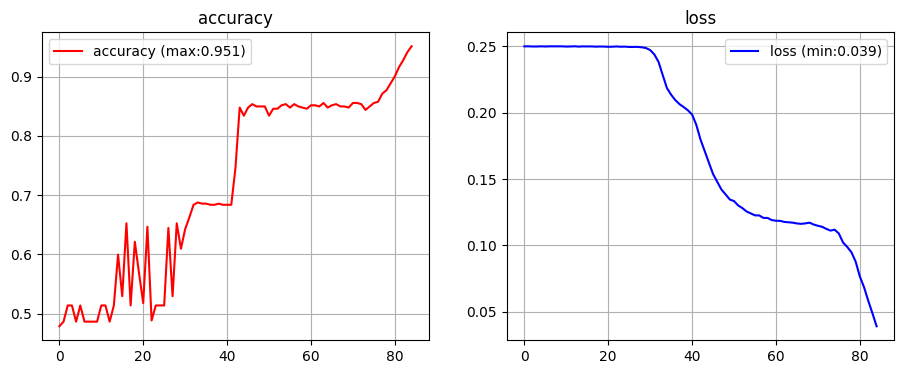

In [75]:
# история изменения значений погрешности модели
fig,ax = plt.subplots(ncols=2,figsize=(11,4))
ax[0].plot(acc_history,label=f'accuracy (max:{max(acc_history):.3f})',c='r' )
ax[0].grid()
ax[0].set_title('accuracy')
ax[0].legend()
ax[1].plot(loss_history,label=f'loss (min:{min(loss_history):.3f})',c='b' )
ax[1].grid()
ax[1].set_title('loss')
ax[1].legend()

In [76]:
# fig,ax = plt.subplots(ncols=2, figsize=(8,3),)
# ax[0].plot(acc_history,c='r')
# ax[0].set_title(f'acc_history,max:{max(acc_history):.3f}')
# ax[0].grid()
# ax[1].plot(loss_history,c='b')
# ax[1].set_title(f'loss_history,min:{min(loss_history):.3f}')
# ax[1].grid()

# тестируем

In [77]:
from sklearn.metrics import classification_report

predicted = model.predict(x_test)

print(classification_report( target_test, predicted) )

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       263
           1       0.93      1.00      0.96       249

    accuracy                           0.96       512
   macro avg       0.96      0.96      0.96       512
weighted avg       0.96      0.96      0.96       512



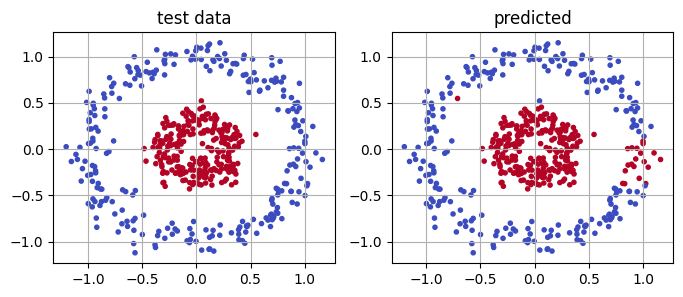

In [78]:
fig,ax = plt.subplots(1,2, figsize=(8,3),)
ax[0].scatter(x=x_test[:,0],y=x_test[:,1],c=target_test, marker='.', cmap='coolwarm')
ax[0].set_title('test data')
ax[0].grid()
ax[1].scatter(x=x_test[:,0],y=x_test[:,1],c=predicted, marker='.', cmap='coolwarm')
ax[1].set_title('predicted')
ax[1].grid()

## карта скоров

In [79]:
# строим сетку 

n = 50 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( x_test[:,0].min()-0.1, x_test[:,0].max()+0.1, n), 
    np.linspace( x_test[:,1].min()-0.1, x_test[:,1].max()+0.1, n)
) # узлы сетки
display( ( xx.shape, yy.shape ) )

xy = np.vstack([xx.ravel(),yy.ravel() ]).T # разворачиваем сетку 
display( xy.shape )

# plt.figure(figsize=(7,7))
# plt.scatter( x=xy[:,0], y=xy[:,1], s=1 )
# plt.show()

((50, 50), (50, 50))

(2500, 2)

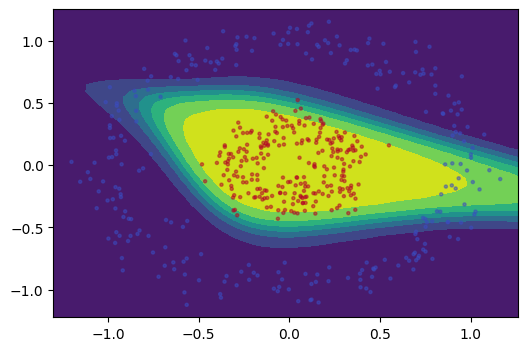

In [80]:
from sklearn.preprocessing import MinMaxScaler

# вычисляем скор для каждого узла сетки
score_xy = model.forward(xy)[:,[1]]
score_xy = MinMaxScaler(feature_range=(0.,1.)).fit_transform( score_xy )
score_xy = score_xy.reshape(n,n) 

from matplotlib.colors import ListedColormap
fig,ax = plt.subplots(figsize=(6,4),sharey=True)
ax.contourf(xx, yy, score_xy )
ax.scatter( x=x_test[:,0], y=x_test[:,1], c=target_test, alpha=.5, s=5,  cmap='coolwarm' )
#ax[0].grid()

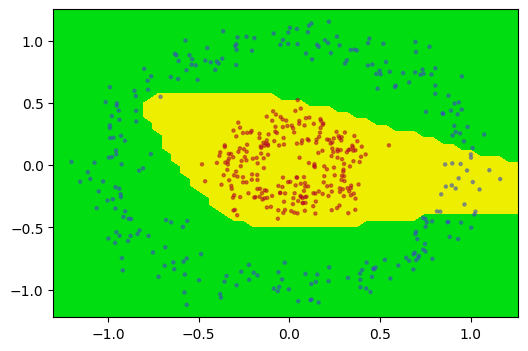

In [81]:
# вычисляем скор для каждого узла сетки
predict_xy = model.predict( xy ).reshape(n,n) 

fig,ax = plt.subplots(figsize=(6,4),sharey=True)
ax.contourf(xx, yy, predict_xy, cmap=ListedColormap(['#0d1','#ee0']) )
ax.scatter( x=x_test[:,0], y=x_test[:,1], c=target_test, alpha=.5, s=5,  cmap='coolwarm' )